In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

plt.rcParams['agg.path.chunksize'] = 10000

df = pd.read_csv('train.csv',index_col=0);

df_terminus = df.index.values[-1]
batches = int(df_terminus/50)
seconds_in_batch = 50
freq = 10000

base = np.array([])
for batch in range(batches):
    mini_array = np.ones(seconds_in_batch*freq)*batch
    base = np.append(base,mini_array)

df['batch'] = base
df['batch'] = df['batch'].astype('int')

10
5000000


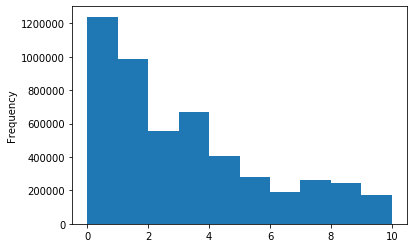

In [14]:
df.open_channels.plot.hist(bins=10)


Collectively, we can see that there are far more times when the number of open channels is small compared to large. However, the classes are not grossly imbalanced.

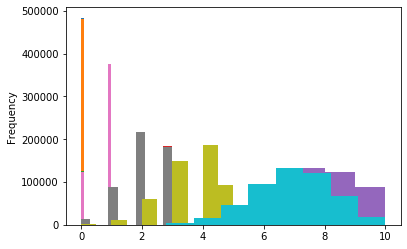

In [17]:
for batch_number in df['batch'].unique():
    df[df['batch']==batch_number].open_channels.plot.hist(bins=10)

When we look at each batch individually, we can see that they have very different distributions of open_channels values.


I want to try some sklearn models which can balance classes. But I don't want to waste time computing, so I'll 
use really simple signal values.

In [43]:
X = df.signal.values
X = X.reshape(-1,1)
y = df.open_channels.values

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.20, random_state=42)

Now let's try implementing the ordinal classifier
https://towardsdatascience.com/simple-trick-to-train-an-ordinal-regression-with-any-classifier-6911183d2a3c

In [31]:
from sklearn.base import clone


class OrdinalClassifier():
    
    def __init__(self, clf):
        self.clf = clf
        self.clfs = {}
    
    def fit(self, X, y):
        self.unique_class = np.sort(np.unique(y))
        if self.unique_class.shape[0] > 2:
            for i in range(self.unique_class.shape[0]-1):
                # for each k - 1 ordinal value we fit a binary classification problem
                binary_y = (y > self.unique_class[i]).astype(np.uint8)
                clf = clone(self.clf)
                clf.fit(X, binary_y)
                self.clfs[i] = clf
    
    def predict_proba(self, X):
        clfs_predict = {k:self.clfs[k].predict_proba(X) for k in self.clfs}
        predicted = []
        for i,y in enumerate(self.unique_class):
            if i == 0:
                # V1 = 1 - Pr(y > V1)
                predicted.append(1 - clfs_predict[y][:,1])
            elif y in clfs_predict:
                # Vi = Pr(y > Vi-1) - Pr(y > Vi)
                 predicted.append(clfs_predict[y-1][:,1] - clfs_predict[y][:,1])
            else:
                # Vk = Pr(y > Vk-1)
                predicted.append(clfs_predict[y-1][:,1])
        return np.vstack(predicted).T
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

Let's start with a multiclass logistic regression

In [37]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0)

clf_ordinal = OrdinalClassifier(clf)

X_train.shape

clf_ordinal.fit(X_train,y_train)

preds_val = clf_ordinal.predict(X_val)

In [45]:
(preds_val == y_val).mean()

0.33787222222222224

Interesting. So now we only have 33% accuracy when the classes' ordinality is addressed. This is actually quite encouraging as I think it means the model is predicting a variety of targets instead of just 0.

In [46]:
print('f1 score for vals is ', f1_score(y_val, preds_val, average='macro'))

f1 score for vals is  0.19297993133718946


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Now that f1 score is quite terrible but, remember, we are really only using 1 feature.

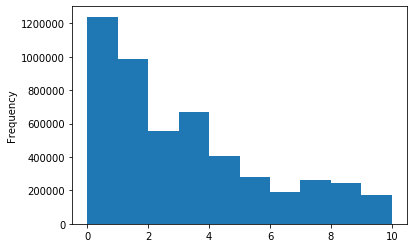

In [47]:
df.open_channels.plot.hist(bins=10)

(array([267499., 231801.,      0., 247214.,  41399.,      0.,      0.,
         26317.,  69136.,  15643.,    991.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5]),
 <a list of 11 Patch objects>)

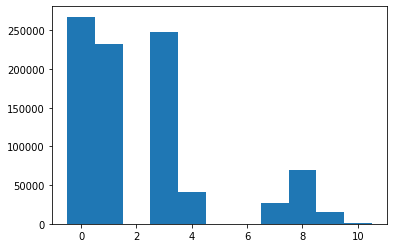

In [52]:
bins_val = np.arange(0, preds_val.max() + 1.5) - 0.5

plt.hist(preds_val,bins=bins_val)

Very unusual behaviour here. It seems that some categories are missing completely. Notably 2,5,6. This may be a reflection of the fact that 2,5,6 are unusually distributed, being lower than their neighbours in some cases. I wonder what would happen if we tried to use logistic regression to 'weight' the classes in the original sklearn logreg model.

In [54]:
(preds_val==5).mean()

0.0

In [56]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0,class_weight = 'balanced')

clf_ordinal = OrdinalClassifier(clf)

clf_ordinal.fit(X_train,y_train)

preds_val = clf_ordinal.predict(X_val)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs

In [57]:
(preds_val == y_val).mean()

0.2908788888888889

So overall accuracy is decreased. Let's see how the f1 score is doing.

In [58]:
print('f1 score for vals is ', f1_score(y_val, preds_val, average='macro'))

f1 score for vals is  0.10377257902264127


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Damn, the f1 score is even less! So that didn't work so well. Let's look at the distribution of predictions.

(array([362417., 231063.,      0.,      0.,      0.,      0.,      0.,
          5825., 102573.,  58082., 140040.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5]),
 <a list of 11 Patch objects>)

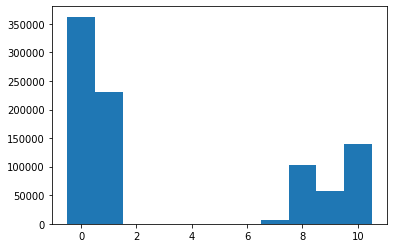

In [59]:
plt.hist(preds_val,bins=bins_val)

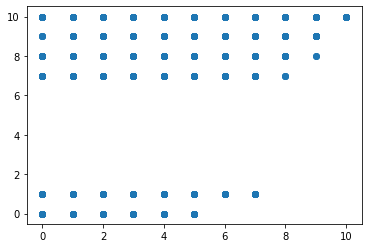

In [60]:
plt.scatter(y_val,preds_val)

Not good at all!

So, both with and without class weighting, let's confirm that using ordinal classification is good.

In [62]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0,class_weight = 'balanced')

clf_ordinal = OrdinalClassifier(clf)

clf_ordinal.fit(X_train,y_train)

clf_original = clf.fit(X_train,y_train)

preds_val_ord = clf_ordinal.predict(X_val)

preds_val_orig = clf_original.predict(X_val)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs

In [63]:
print('f1 score for vals_ords is ', f1_score(y_val, preds_val_ord, average='macro'))
print('f1 score for vals_orig is ', f1_score(y_val, preds_val_orig, average='macro'))

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1 score for vals_ords is  0.10377257902264127
f1 score for vals_orig is  0.1498020870279787


f1 score for vals_ords is  0.10377257902264127
f1 score for vals_orig is  0.1498020870279787

Hmmmmm, so when classes are weighted, using ordinal approach actually makes it worse! Let's see what happens when classes are not weighted.

In [69]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0)

clf_ordinal = OrdinalClassifier(clf)

clf_ordinal.fit(X_train,y_train)

clf_original = clf.fit(X_train,y_train)

preds_val_ord = clf_ordinal.predict(X_val)

preds_val_orig = clf_original.predict(X_val)

print('f1 score for vals_ords w/o weighting is ', f1_score(y_val, preds_val_ord, average='macro'))
print('f1 score for vals_orig w/o weighting is ', f1_score(y_val, preds_val_orig, average='macro'))

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs

f1 score for vals_ords w/o weighting is  0.19297993133718946
f1 score for vals_orig w/o weighting is  0.14265005378792367


Interesting. We can see here that when weights are ignored, the use of ordinal data significantly increases the f1 score.